# Skill assessment
***

**Author**: Chus Casado<br>
**Date**: 13-02-2023<br>

**Introduction**:<br>


**Questions**:<br>

* Should we resample to 12-hourly timesteps?
* What if every event is supposed to last 12 h?

**Tasks to do**:<br>

* [ ] Compute skill only in stations with a KGE over a threshold.
* [ ] Average `f1` score for each station.
* [ ] Fix the number of events plot inside function `plot_skill`
* [ ] Plots with only stations with observed events

**Interesting links**<br>
[Pythonic way to perform statistics across multiple variables with Xarray](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

In [57]:
# colormap used for the maps
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('f1 cmap', cmaplist, cmap.N)
bounds = np.arange(0, 1.01, .1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

## 1 Data

In [2]:
name = 'global'
folders = os.listdir('results/')

In [3]:
# path where results will be saved
path_out = f'results/skill/{name}/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [4]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

### 1.1 Stations 

In [5]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'results/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

# add columns where skill will be saved
new_cols = [f'f1_{model}' for model in ['current', 'model_mean', 'member_weighted']]
stations[new_cols] = np.nan

no. stations:			959


In [6]:
# shapefile with rivers
rivers_shp = gpd.read_file(f'../data/GIS/RiversForWebPage_EU_ready.shp')
mask = rivers_shp.BASIN.isin(catchments)
rivers_shp = rivers_shp.loc[mask]

### 1.2 Reanalysis: exceedance & events

I load the preprocessed reanalysis data. In this [notebook](2_2_reanalysis_preprocessing.ipynb) the reanalysis discharge data was preprocessed to create timeseries of exceedance over the 5-year return period threshold.

Out of the exceedance timeseries I calculate another timeseries of the onset of flood events.

In [7]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
#start, end = datetime(2021, 1, 1, 6), datetime(2022, 1, 1, 6) + timedelta(hours=39*6)
start, end = datetime(2021, 1, 1, 6), datetime(2022, 1, 10, 12)
rean_exc = rean_exc.loc[start:end, stations.index.tolist()]

In [8]:
# # load probability of exceeding the discharge threshold in the REANALYSIS data
# rean_onsets = pd.read_parquet(f'{path_reanalysis}/events_rl5.parquet')
# rean_onsets.columns = rean_onsets.columns.astype(int)
# rean_onsets = rean_onsets.loc[start:end, stations.index.tolist()]
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

In [9]:
# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))

no. events:			357


In [10]:
# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))
# stations = stations.loc[mask_stn,:]
# rean_exc = rean_exc.loc[:,mask_stn]
# rean_onsets = rean_onsets.loc[:,mask_stn]
# print('no. stations with events:\t{0}'.format(stations.shape[0]))

no. stations with events:	250


### 1.3 Exceedance forecast

I load the preprocessed forecast data. In a previous [notebook](4_0_forecast_exceedance_review.ipynb), the forecasted discharge was converted to probability of exceeding the 5-year return period threshold. The ouput of that process is a NetCDF file per station with the forecasted probability of exceedance. 

In [11]:
# models
models = {'COS': {'members': 20, 'leadtimes': 23},
          'DWD': {'members': 1, 'leadtimes': 29},
          'EUD': {'members': 1, 'leadtimes': 40},
          'EUE': {'members': 51, 'leadtimes': 40},}

min_leadtime = min([models[m]['leadtimes'] for m in models])

In [12]:
# load probability of exceeding the discharge threshold in the FORECAST data
path_forecast = '../data/exceedance/forecast/'

fore_exc = {}
for stn in stations.index:
    da = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')
    if 'id' in da.coords:
        da = da.drop_vars('id')
    fore_exc[stn] = da
    da.close()

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model,
                                        'forecast': fore_exc[stn].forecast,
                                        'leadtime': fore_exc[stn].leadtime})

In [75]:
xr.open_mfdataset(f'{path_forecast}*.nc', , parallel=True)

ValueError: When combine='by_coords', passing a value for `concat_dim` has no effect. To manually combine along a specific dimension you should instead specify combine='nested' along with a value for `concat_dim`.

In [13]:
# DataArray with weights for each model and leadtime
weights_member = np.zeros((len(fore_exc.model), len(fore_exc.leadtime)))
for i, (key, value) in enumerate(models.items()):
    leadtimes = value['leadtimes']
    members = value['members']
    weights_member[i,:leadtimes] = members
weights_member = xr.DataArray(weights_member, coords={'model': list(models), 'leadtime': fore_exc.leadtime})

In [39]:
# import weights based on the Brier score
weights_brier = xr.open_dataarray('results/weights_brier.nc')
weights_brier.close()
# resample to the 6-hourly resolution
weights_brier['leadtime'] = weights_member.leadtime[::2]
weights_brier = weights_brier.interp_like(weights_member, method='nearest').fillna(0)
weights_brier[dict(leadtime=-1)] = weights_brier.isel(leadtime=-2)

## 2 Compute events

In this section I will create two boolean _DataArray_ with the onset of flood events, i.e., a matrix of zeros and ones where a one means the beginning of a flood.

* `obs_onsets` is a _DataArray_ with three dimensions that contains the "observed" events: 
    * `id`: the stations ID
    * `forecast`: the timestamp of the beginning of the forecast
    * `leadtime`: the timedelta of the specific timestep. The addition of forecast and leadtime renders the actual date and time of the timestep
* `pred_events` is a _DataArray_ with five dimensions that contains the forecasted events:
    * `id`
    * `forecast`
    * `leadtime`
    * `model` corresponds to the different procedures to compute the occcurrence of events.
        * `current` is the current EFAS criteria, i.e., at least a deterministic model must predict the flood, and one of the probabilistic models must predict a probability of event higher than a probability threshold.
        * `model_mean` computes total probability giving the same weight to every model, i.e., 25% weight to each of the 4 meteorological forcings.
        * `member_weighted` computes total probability giving the same weight to each run, i.e., probabilistic models (with more than 1 run) have a higher weight.
    * `probability` are different thresholds to consider a flood event.

In [15]:
# dprobability thresholds
thresholds = np.arange(0.05, .96, .05).round(2)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

In [16]:
# OBSERVED EVENTS & ONSETS
# ........................
    
obs_onsets = {}
obs_events = {}
for i, stn in enumerate(stations.index): 
    # find onsets
    mask = rean_onsets[stn]
    onsets = rean_onsets.index[mask].tolist()
    obs_onsets[stn] = dataarray_events(onsets, fore_exc.forecast, fore_exc.leadtime)
    
    # find events
    mask = rean_exc[stn]
    exc = rean_exc.index[mask].tolist()
    # create DataArray of the occurrence of events
    obs_events[stn] = dataarray_events(exc, fore_exc.forecast, fore_exc.leadtime)
    
obs_onsets = xr.Dataset(obs_onsets).to_array(dim='id', name='events')
obs_events = xr.Dataset(obs_events).to_array(dim='id', name='events')

```Python
stn = 119

fig, axes = plt.subplots(nrows=2, figsize=(16, 8), sharex=True, sharey=True)

for ax, da in zip(axes, [obs_events.sel(id=stn), obs_onsets.sel(id=stn)]):
    sns.heatmap(da.transpose(), ax=ax, cmap='Blues')
    ax.tick_params(length=0)
```

In [40]:
# PREDICTED EVENTS & ONSETS
# .........................

# CURRENT CRITERIA

# compute events for each probability threshold

# compute exceendace of probability thresholds
current = fore_exc.to_array(dim='id', name='current')
exceedance0 = current > probabilities
# find where the deterministic criteria was fulfilled
deterministic = exceedance0.sel(model=['DWD', 'EUD']).sum('model')
# find where the probabilistic criteria was fulfilled
probabilistic = exceedance0.sel(model=['COS', 'EUE']).sum('model')
# find where both the deterministic and the probabilistic criteria was fulfilled
events0 = ((deterministic >= 1) & (probabilistic >= 1))

# compute the onset of events for each probability threshold

steps0 = events0.astype(int).diff('leadtime') == 1
step0_0 = events0.isel(leadtime=0)
onsets0 = xr.concat((step0_0, steps0), 'leadtime')

# NEW CRITERIA

# compute events for each probability threshold and two new criteria: model mean, weighted mean
model_mean = fore_exc.mean('model').to_array(dim='id', name='model_mean')
member_weighted = fore_exc.weighted(weights_member).mean('model').to_array(dim='id', name='member_weighted')
brier_weighted = fore_exc.weighted(weights_brier).mean('model').to_array(dim='id', name='brier_weighted')
exceedance12 = xr.merge([model_mean, member_weighted, brier_weighted])
events12 = exceedance12 > probabilities

# compute the onset of events for each probability threshold
steps12 = events12.astype(int).diff('leadtime') == 1
step12_0 = events12.isel(leadtime=0)
onsets12 = xr.concat((step12_0, steps12), 'leadtime')

# join the three criteria
pred_events = xr.merge([events0.to_dataset(name='current'), events12]).to_array(dim='model', name='events')
pred_onsets = xr.merge([onsets0.to_dataset(name='current'), onsets12]).to_array(dim='model', name='onsets')

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.1 Skill within a forecast

In this first analysis I will check how EFAS performs at the forecast level. For that, I will aggregate the events _DataArray_ in the `leadtime` dimension, so the resulting _DataArray_ will have one dimension less and it will represent the forecasts in which there were observed (`obs_fc`) and/or predicted (`pred_fc`) events.

In [44]:
# observed events in each forecast
obs_fc = obs_events.any('leadtime')

# predicted events in each forecast
pred_fc = pred_events.any('leadtime')

# compute sums of hits and falses
tp = ((obs_fc == 1) & (pred_fc == 1)).sum('forecast')
fn = ((obs_fc == 1) & (pred_fc == 0)).sum('forecast')
fp = ((obs_fc == 0) & (pred_fc == 1)).sum('forecast')

# compute metrics and save in a Dataset
results1 = xr.Dataset({'recall': tp / (tp + fn),
                        'precision': tp / (tp + fp),
                        'f1': 2 * tp / (2 * tp + fn + fp)})

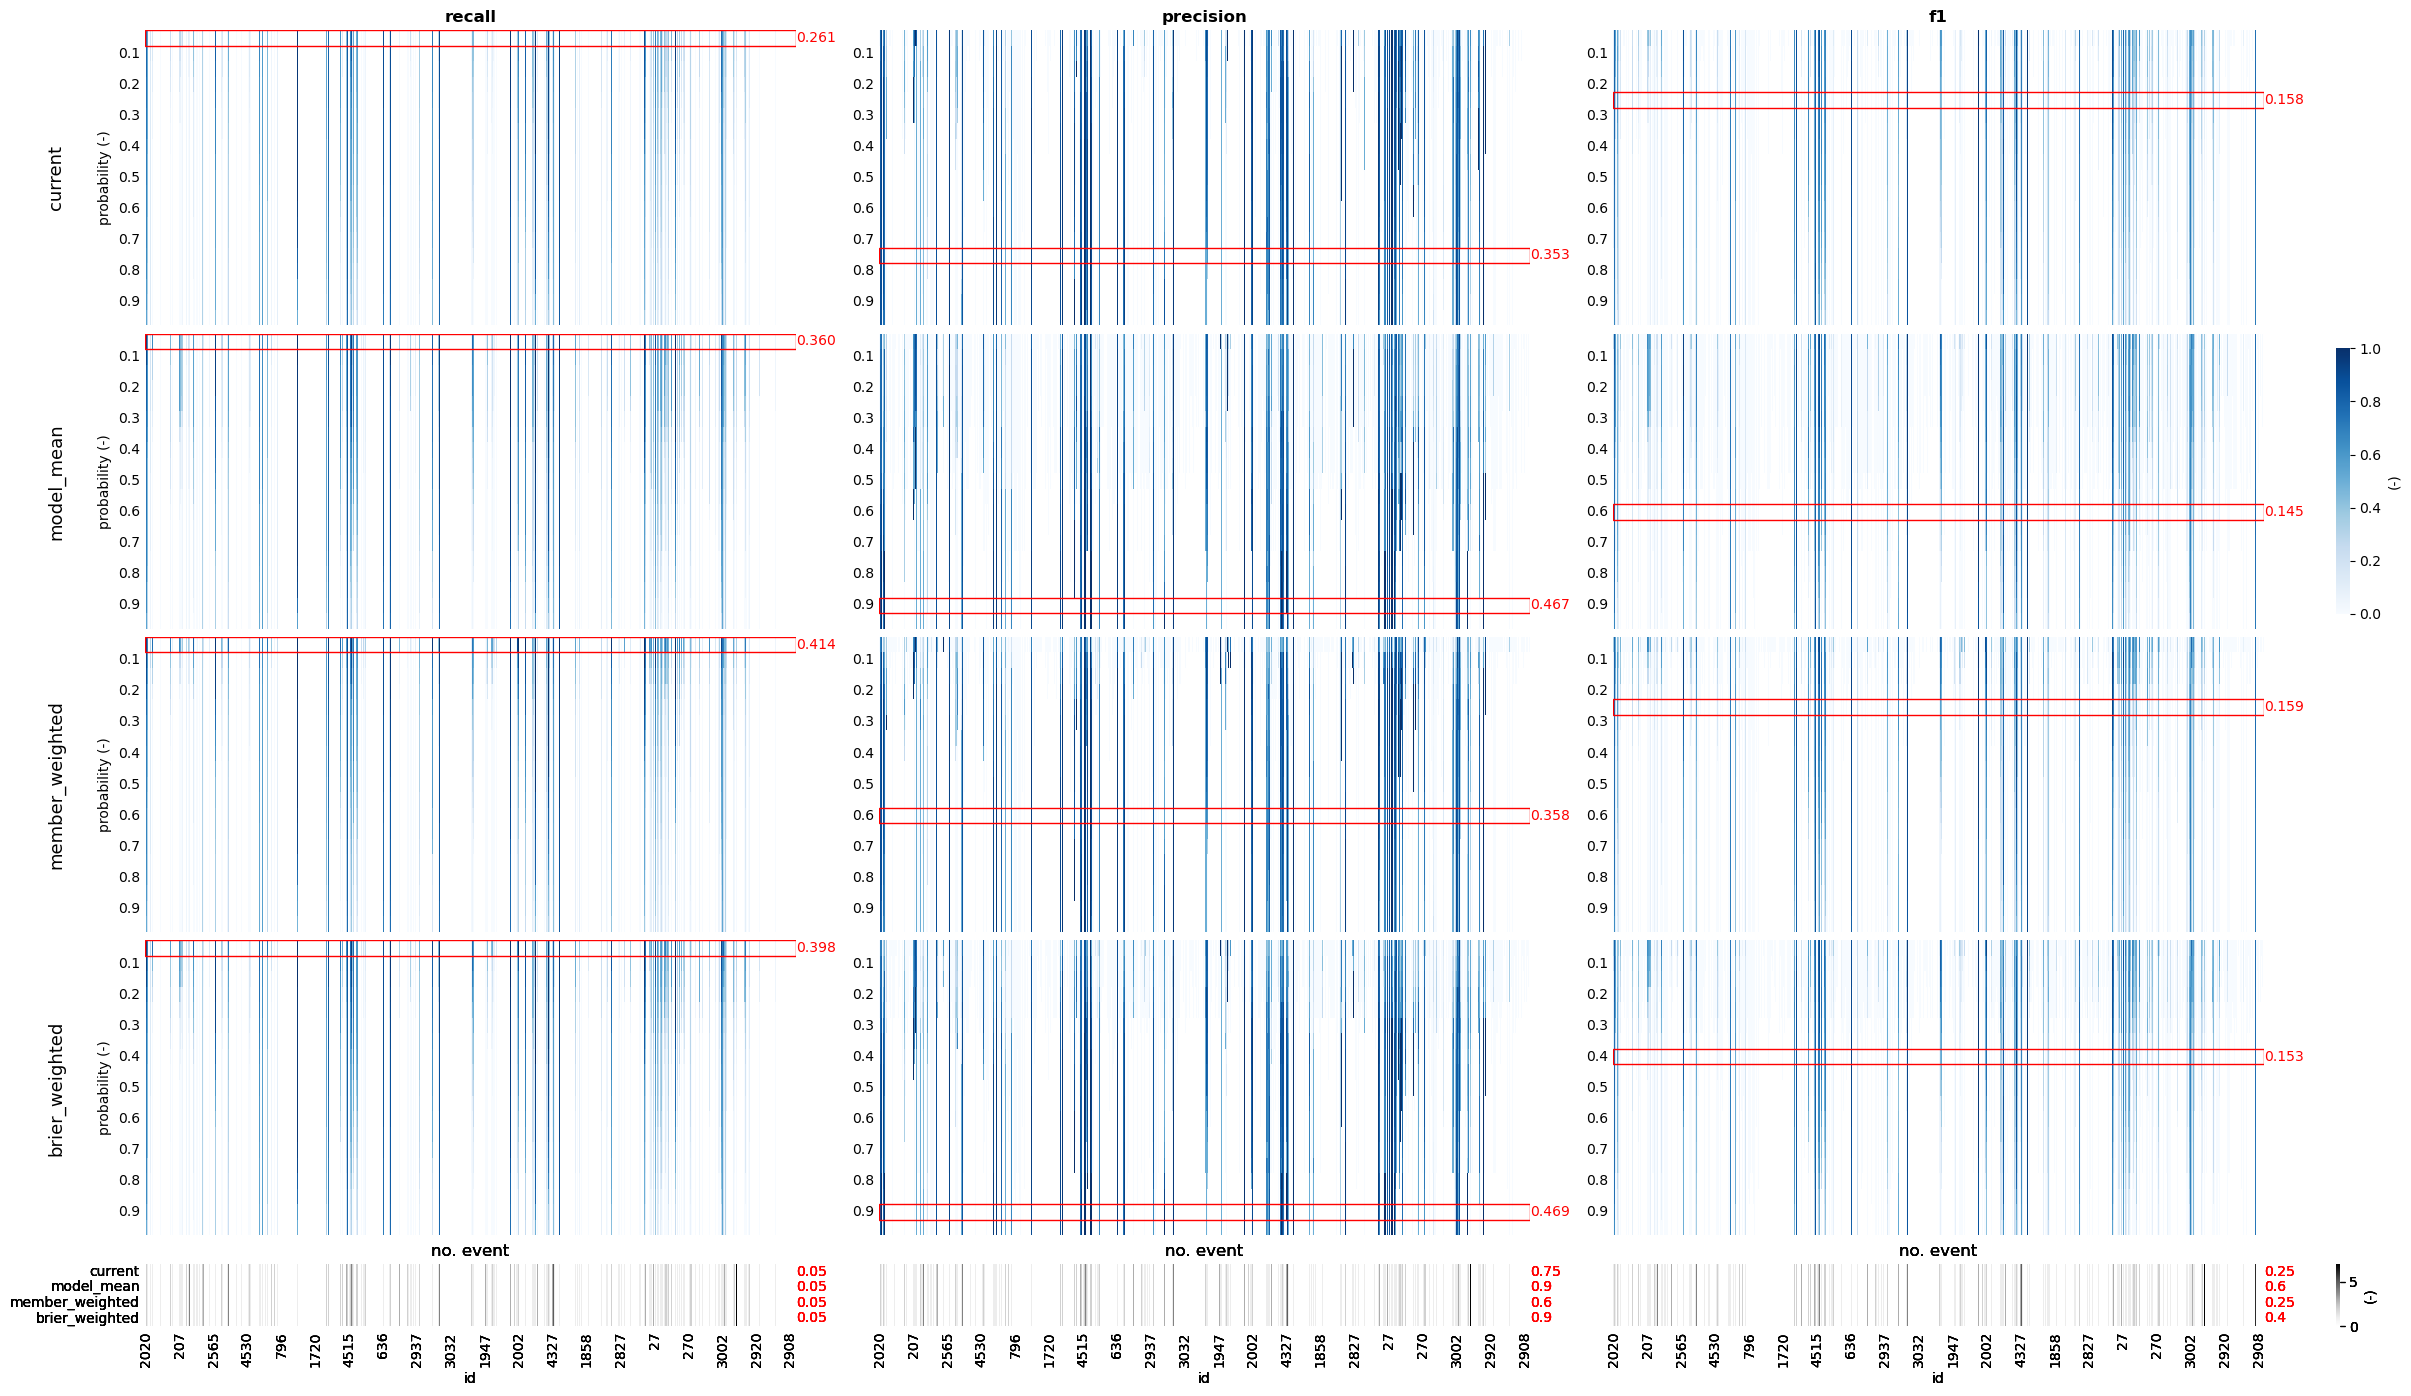

In [46]:
# plot results
filename = f'{path_out}/forecast_skill - station_vs_model.jpg'
plot_skill(results1, rean_onsets.sum(), xtick_step=50, save=filename, figsize=(24, 14))

The plot above shows the performance in terms of forecasts that predicted a flood and the flood actually occurred. The leadtime for the flood is not taking into account at this point; I consider a hit a forecast that predicts a flood at any leadtime and there actually was a flood during the complete forecasted period. 

The graph contains 15 plots distributed in 3 columns and 5 rows. Each column represents a metric: f1 (the harmonic mean of precision and recall), precision (proportion of predicted floods that were right), and recall (proportion of observed floods that were predicted). The top 3 rows represent each of the prediction criteria; they are heatmaps of the corresponding metric depending on the station and the probability threshold; the red rectangle shows the best probability threshold for that specific criteria and metric. The plots in the fourth row aggregate the red rectangles in a single plot to ease the comparison among criteria. The plots in the last row show for the amount of forecast with flood events; it is the same plot for the 3 columns.

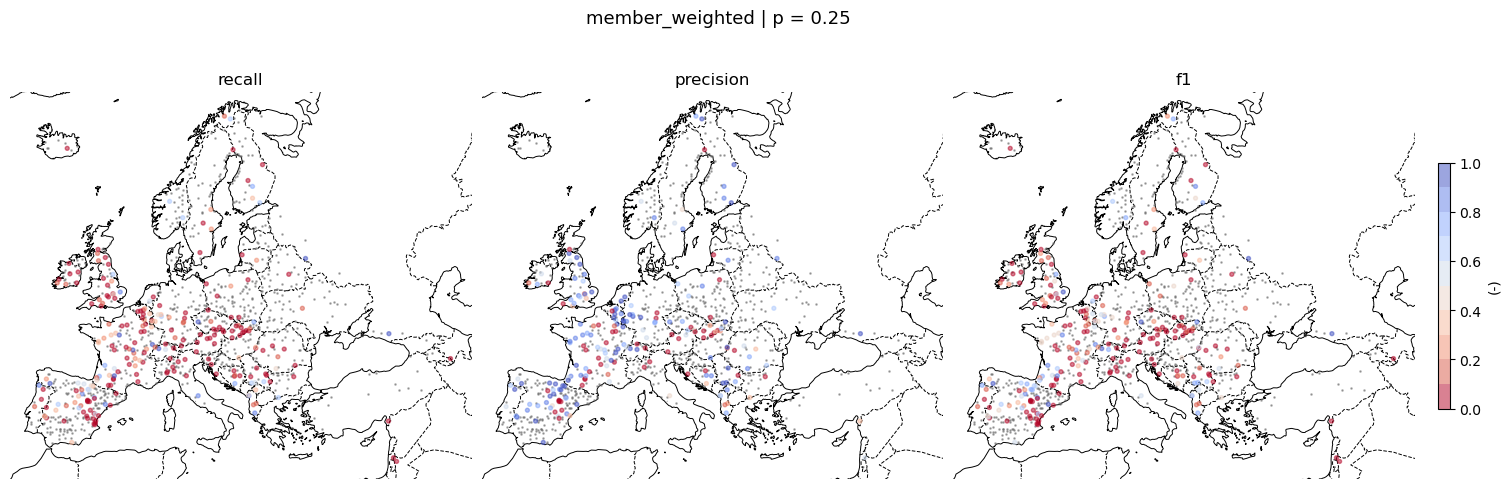

In [56]:
# # find probability threshold that optimizes f1 for a given model
# metric = 'f1'
model = 'member_weighted'
best_p = results1['f1'].sel(model=model).mean('id').idxmax(dim='probability', skipna=True)

# plot a map of the metrics
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, (metric, da) in zip(axes, results1.items()):
    # extract metric values for stations
    metric_id = da.sel(model=model, probability=best_p).to_pandas()
    # plot a map of the Brier score for the COS model
    plot_map_stations(stations.X, stations.Y, metric_id, mask=~mask_stn, ax=ax,
                      rivers=None, size=8, cmap=cmap, norm=norm, title=metric)
fig.text(.475, 1.025, f'{model} | p = {best_p.data:.2f}', horizontalalignment='center', fontsize=13)
fig.colorbar(plot_map_stations.colorbar, shrink=.5, label=f'(-)');

# plt.savefig(f'{path_out}eventwise_skill_map_(stations_with_events).jpg', bbox_inches='tight', dpi=300)

The $f1$ score is rather low in most of the stations. This is mainly caused by a poor $recall$, i.e., the system misses events. On the contrary, most of the stations have a $precision$ over 0.5, which means that there aren't many false positives.

### 3.2 Skill predicting the onset of the flood

In this section the analysis will be harder, and we will assess the EFAS skill at predicting the correct time of the onset of the event. Since the first tries proved that predicting the exact time of the onset is an extremely complicated task, we will consider various time windows around the observed event. A window of 3 timesteps, for instance, considers a hit when the EFAS forecast predicts the onset of the flood with an error of $\pm6\,h$.

#### 3.2.1 Find hits, misses and false alarms

After several tries, I've found a way to compute quickly and easily the skill metrics. It's importance to notice that skill metrics can't be aggregated (added or averaged) because they are quotions with an addition in the denominator. Therefore, the analysis must start computing the hits (true positives), misses (false negatives) and false alarms (false positives) without any aggregation. This first step is done in this section.

As mentioned earlier, the probability of predicting the onset of an event at the right time is very, very low. Therefore, we need to add certain flexibility in what's considered a hit, i.e., we will consider hits predictions close enough (with an offset of 1 or 2 timesteps). I came up with a procedure to count hits, misses and false alarms taking into account this flexibility on the leadtime. The plot below explains it graphically.

1. I compute a rolling sum over both the observed and predicted events. The width of the window is the flexibility we accept in the leadtime.
2. I apply a mask based on the observed events over the rolling sum of predicted events (top, right). From this matrix we can count the **true positives** (ones) and the **false negatives** (zeros).
3. I apply a mask based on the inverse of the rolling sum of observed events over the predicted events (bottom, right). The sum of ones in this matrix are the **false alarms**.

In [61]:
pred_onsets.dtype

dtype('bool')

In [62]:
pred_onsets.size

2128212800

In [68]:
np.prod(pred_onsets.shape)

2128212800

In [71]:
import sys

In [72]:
sys.getsizeof(pred_onsets)

96

In [70]:
xr.CFTimeIndex.memory_usage(pred_onsets)

AttributeError: 'DataArray' object has no attribute '_memory_usage'

In [60]:
# number of timesteps surrounding the actual event
windows = [1, 3, 5]

hits = {var: {w: {} for w in windows} for var in ['tp', 'fn', 'fp']}
for w in windows:
    # rolling sum of observations and predictions
    mp = int(w / 2) + 1
    obs_w = obs_onsets.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    pred_w = pred_onsets.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    
    # compute true positives and false negatives
    aux1 = pred_w.where(obs_onsets == 1)
    tp, fn = (aux1 == 1), (aux1 == 0)
    
    # compute false positives
    aux2 = pred_onsets.where(obs_w == 0)
    fp = (aux2 == 1)
       
    # save results  
    hits['tp'][w] = tp
    hits['fn'][w] = fn
    hits['fp'][w] = fp

# convert results into a Dataset
data_vars = {var: xr.Dataset(dct).to_array(dim='window', name=var) for var, dct in hits.items()}
hits = xr.Dataset(data_vars)
# hits['leadtime'] = (pred_onsets.leadtime / 3600e9).astype(int)

hits.dims

MemoryError: Unable to allocate 15.9 GiB for an array with shape (4, 959, 730, 19, 40) and data type object

The resulting `hits` _Dataset_ has 6 dimensions: `model`, `forecast`, `leadtime`, `probability`, `id`, `window`. In the following subsection I will compute the skill metrics from this Dataset using diverse aggregations over these dimension.

In [ ]:
pred_

#### 3.2.2 Aggregation over forecast and leadtime

Once computed the hits and misses for different time windows, the first approach will be to compute the metrics (f1, recall and precision) aggregating them over the dimensions `forecast` and `leadtime`. The resulting metrics have 4 dimensions: `model`, `probability`, `id` and `window`.

In [ ]:
# compute skill
results22 = compute_metrics(hits, ['forecast', 'leadtime'])
print(results22.dims)

**Plot id vs window**

In [ ]:
# plot results for a model depending on the window
model = 'weighted_mean'
filename = f'{path_out}/{model}_skill - station_vs_window.jpg'
plot_skill(results22.sel(model=model), rean_events.sum(), rowdim='window',
           save=filename, xtick_step=8)

**Plot id vs model**

In [ ]:
# plot results for a window depending on the model
window = 5
filename = f'{path_out}/{model}_skill - station_vs_model.jpg'
plot_skill(results22.sel(window=window), rean_events.sum(), rowdim='model', xtick_step=8,
           save=filename)

#### 3.2.3 Aggregation over forecast and station

The second approach is to aggregate the hits/misses _Dataset_ over the dimensions `forecast` and `station`, so we can check how performance changes over `leadtime`.

In [ ]:
# compute skill
results23 = compute_metrics(hits, ['forecast', 'id'])
print(results23.dims)

**Plot leadtime vs window**

In [ ]:
# plot results for a model depending on the window
model = 'weighted_mean'
filename = f'{path_out}/{model}_skill - leadtime_vs_window.jpg'
plot_skill(results23.sel(model=model), xdim='leadtime', ydim='probability', rowdim='window', xtick_step=2,
           save=filename)

##### Limiting leadtime to 7 days

In [ ]:
# ploat results for a model depending on the window
plot_skill(results23.sel(model='weighted_mean', leadtime=slice(None, 7 * 24)),
           xdim='leadtime', ydim='probability', rowdim='window', xtick_step=2)

**Plot leadtime vs model**

In [ ]:
# plot results for a model depending on the window
window = 5
filename = f'{path_out}/{window}_skill - leadtime_vs_model.jpg'
plot_skill(results23.sel(window=window), xdim='leadtime', ydim='probability', rowdim='model',
           save=filename)

##### Limiting leadtime to 7 days

In [ ]:
# plot results for a model depending on the window
plot_skill(results23.sel(window=5, leadtime=slice(None, 7 * 24)),
           xdim='leadtime', ydim='probability', rowdim='model')

##### Resampling hits/misses to 12-hourly resolution

To avoid the noise in the `leadtime` dimension caused by the fact that the model resolution is 6 h, but the forecast frequency is 12 h, I propose to resample the `hits` _Dataset_ to 12 h resolution.

In [ ]:
# resample the dataset of hits and misses
resample_dict = {'leadtime': '12h'}
hits_12h = hits.resample(resample_dict).any()

# compute skill
results23_12h = compute_metrics(hits_12h, ['forecast', 'id'])
results23_12h.dims

**Plot leadtime vs window**

In [ ]:
# plot results for a model depending on the window
plot_skill(results23_12h.sel(model='current'), xdim='leadtime', ydim='probability', rowdim='window', xtick_step=1)

The results are clearer than with the 6-hourly resolution, but show the same pattern:
* Performance increases as we increase the wime window.
* Precision has higher values than recall, which actually requires the minimum probability threshold.
* Skill is higher at shorter leadtimes, with the exception of the first step.

**Plot leadtime vs model**

In [ ]:
# plot results for a model depending on the window
plot_skill(results23_12h.sel(window=5), xdim='leadtime', ydim='probability', rowdim='model', xtick_step=1)

The conclusions are similar to the 6-hourly plot:
* The pattern is similar regardless the model. 
    * Skill increases towards shorter leadtimes (except the first step).
    * Skill maximizes at probability thresholds between in the lower range, but not minium (except recall).
    * Precision values are significantly higher than recall.
* The highest f1 value is found for the `model_mean` and a probability threshold of 35%.